SRAG 2021 e 2022 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19

Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import io
import requests
from sklearn.feature_selection import chi2
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import warnings
from PIL import Image

Datasets

In [3]:
df_original = pd.read_csv('df_preprocessed.csv', delimiter=',')

In [46]:
df = df_original.copy(deep = True)
df.drop(columns=['Unnamed: 0'], inplace= True)

CONSTANTS

In [51]:
FAIXA_ETARIA = ['0-19', '20-24', '25-29', '30-34', '35-39', '40+']
DIC_RACA = {1: 'White', 2: 'Black', 3: 'Others', 4: 'Others', 5: 'Others', 9: 'Ignored'}

FAIXA_ESCOLARIDADE = ['None or Primary incomplete', 'Primary', 'Secondary','College or more']
DIC_ESCOLARIDADE = {0: 'None or Primary incomplete', 1: 'None or Primary incomplete', 2: 'Primary', 3: 'Secondary', 4: 'College or more', 5: 'Ignored', 9: 'Ignored'}

FAIXA_GRAVIDEZ = ['First trimester','Second trimester','Third trimester','Gestation period ignored', 'Puerpera']
DICT_GRAVIDEZ = {1: 'First trimester', 2: 'Second trimester',3: 'Third trimester', 4: 'Gestation period ignored', 5 : 'Puerpera'}

DICT_VACINA = {1: 'at least 1 dose', 2: 'Unvaccinated', 9: 'Ignored'}
FAIXA_VACINA = ['at least 1 dose','Unvaccinated']

FAIXA_REGIAO = ['North','Northeast','Southeast','South','Midwest']


Pre processing

In [48]:
df['CS_RACA'] = df['CS_RACA'].map(DIC_RACA)
df['CS_ESCOL_N'] = df['CS_ESCOL_N'].map(DIC_ESCOLARIDADE)
df['GRAVIDEZ'] = df['GRAVIDEZ'].map(DICT_GRAVIDEZ)

df['VACINA_COV'] = df['VACINA_COV'].fillna(9)
df['VACINA_COV'] =df['VACINA_COV'].astype(int)
df['VACINA_COV'] = df['VACINA_COV'].map(DICT_VACINA)

**Table 1: Sociodemographic and obstetrical characteristics of women with  laboratory confirmed SARS-CoV-2 infection.**

Relationship between covid variant and age

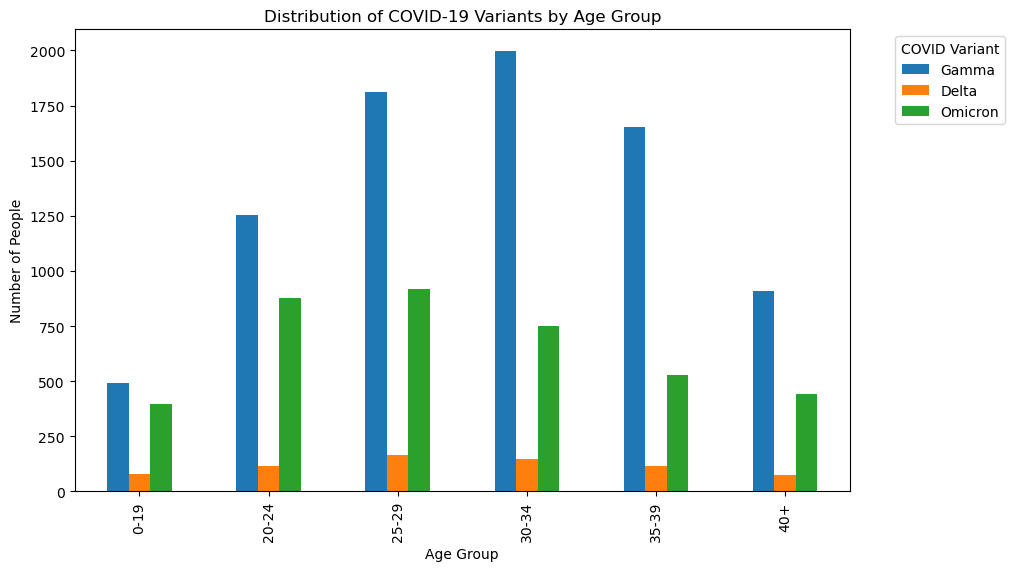

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
0-19,491,6.05%,78,11.22%,398,10.18%,967
20-24,1255,15.46%,117,16.83%,876,22.41%,2248
25-29,1810,22.3%,166,23.88%,918,23.48%,2894
30-34,1996,24.59%,147,21.15%,751,19.21%,2894
35-39,1653,20.37%,115,16.55%,526,13.46%,2294
40+,911,11.22%,72,10.36%,440,11.26%,1423
Total,8116,100.0%,695,100.0%,3909,100.0%,12720


H₀: The two categorical variables have no relationship
p-value : 0.0

Null Hypothesis is rejected.


In [22]:
# Create age groups
bins = [0, 19, 24, 29, 34, 39, float('inf')]

# Add an 'Age_Group' column to the DataFrame
df['Age_Group'] = pd.cut(df['NU_IDADE_N'], bins=bins, labels= FAIXA_ETARIA, right=True)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=FAIXA_ETARIA)

# Count the number of people for each variant in each age group
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].groupby('Age_Group').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

Relationship between covid variant and race/color

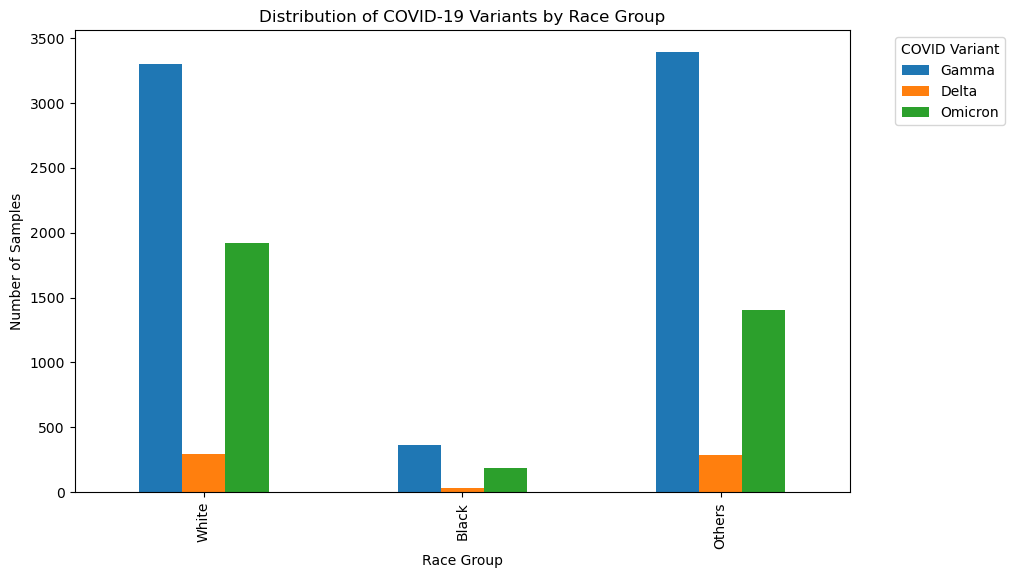

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
White,3297,46.75%,292,47.48%,1918,54.74%,5507
Black,364,5.16%,35,5.69%,185,5.28%,584
Others,3391,48.09%,288,46.83%,1401,39.98%,5080
Total,7052,100.0%,615,100.0%,3504,100.0%,11171


H₀: The two categorical variables have no relationship
p-value : 2.452482661396971e-13

Null Hypothesis is rejected.


In [23]:
# Create age groups
labels = ['White','Black','Others']

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=labels)

# Count the number of people for each variant in each race group
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].loc[df['CS_RACA'] != 'Ignored'].groupby('CS_RACA').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Race Group')
plt.xlabel('Race Group')
plt.ylabel('Number of Samples')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

Relationship between the covid variant and schooling

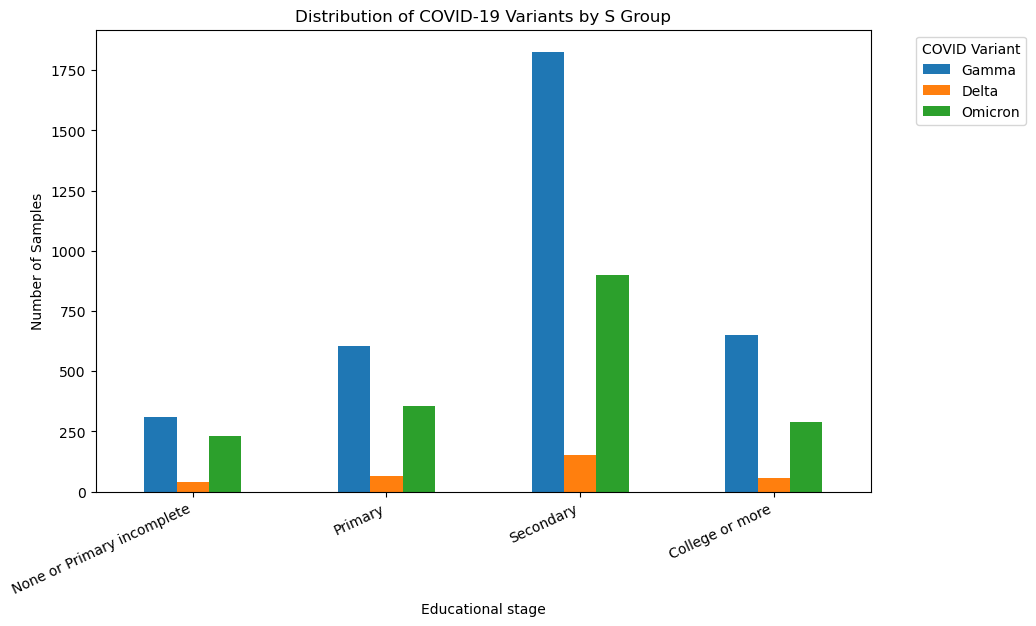

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
None or Primary incomplete,311,9.16%,41,13.23%,229,12.93%,581
Primary,605,17.82%,63,20.32%,354,19.99%,1022
Secondary,1827,53.81%,151,48.71%,899,50.76%,2877
College or more,652,19.2%,55,17.74%,289,16.32%,996
Total,3395,100.0%,310,100.0%,1771,100.0%,5476


H₀: The two categorical variables have no relationship
p-value : 7.599431288241032e-05

Null Hypothesis is rejected.


In [37]:
# Create age groups
labels = FAIXA_ESCOLARIDADE

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=labels)

# Count the number of people for each variant in each Educational stage
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].loc[df['CS_ESCOL_N'] != 'Ignored'].groupby('CS_ESCOL_N').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
ax = plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Educational stage')
plt.xlabel('Educational stage')
plt.ylabel('Number of Samples')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

Analysis of pregnant and postpartum women

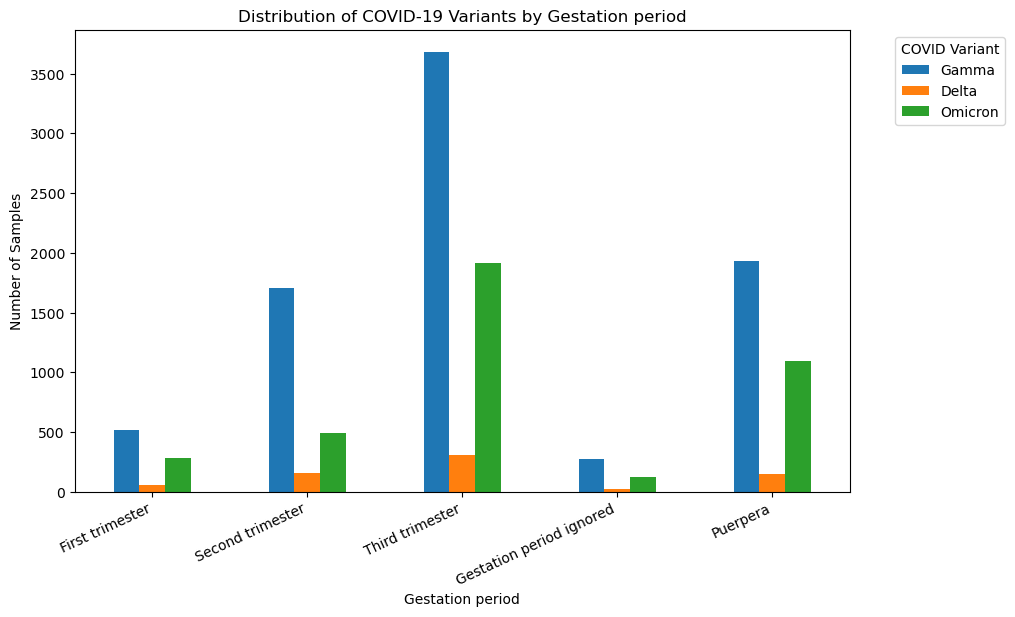

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
First trimester,520,6.41%,55,7.91%,286,7.32%,861
Second trimester,1709,21.05%,162,23.31%,490,12.54%,2361
Third trimester,3682,45.36%,307,44.17%,1912,48.91%,5901
Gestation period ignored,273,3.36%,20,2.88%,128,3.27%,421
Puerpera,1933,23.81%,151,21.73%,1093,27.96%,3177
Total,8117,100.0%,695,100.0%,3909,100.0%,12721


H₀: The two categorical variables have no relationship
p-value : 0.0

Null Hypothesis is rejected.


In [41]:
labels = FAIXA_GRAVIDEZ

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=labels)

# Count the number of people for each variant in each Gestation period
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].groupby('GRAVIDEZ').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
ax = plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Gestation period')
plt.xlabel('Gestation period')
plt.ylabel('Number of Samples')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

Relationship between the covid variant and the vaccine

In [45]:
df['VACINA_COV']

0        9
1        1
2        9
3        9
4        2
        ..
12716    2
12717    1
12718    1
12719    1
12720    1
Name: VACINA_COV, Length: 12721, dtype: int32

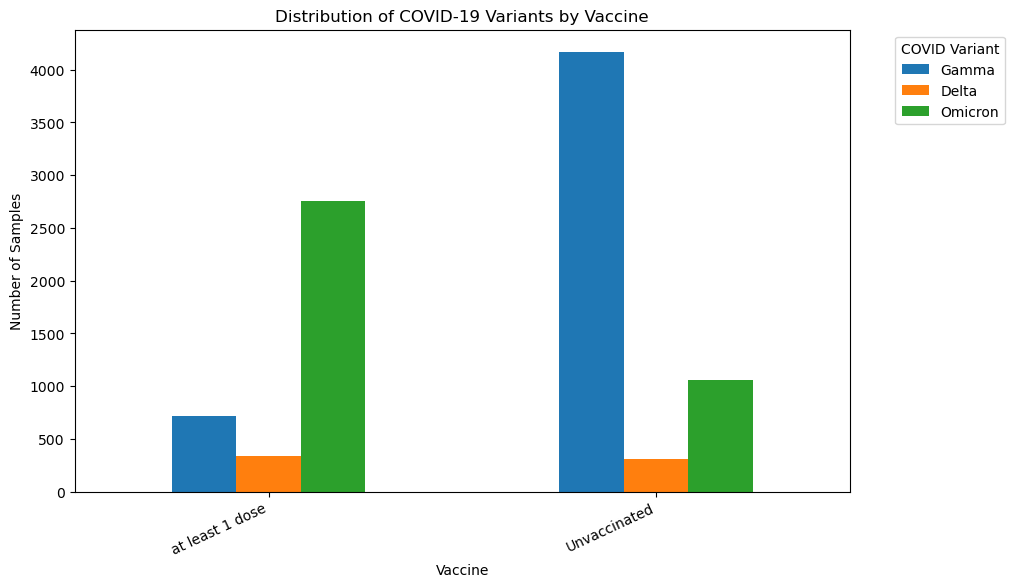

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
at least 1 dose,713,14.6%,337,52.25%,2750,72.22%,3800
Unvaccinated,4170,85.4%,308,47.75%,1058,27.78%,5536
Total,4883,100.0%,645,100.0%,3808,100.0%,9336


H₀: The two categorical variables have no relationship
p-value : 0.0

Null Hypothesis is rejected.


In [49]:
labels = FAIXA_VACINA

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=labels)

# Count the number of people for each variant to Vaccine
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].loc[df['VACINA_COV'] != 'Ignored'].groupby('VACINA_COV').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
ax = plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Vaccine')
plt.xlabel('Vaccine')
plt.ylabel('Number of Samples')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

relationship between region and covid variant

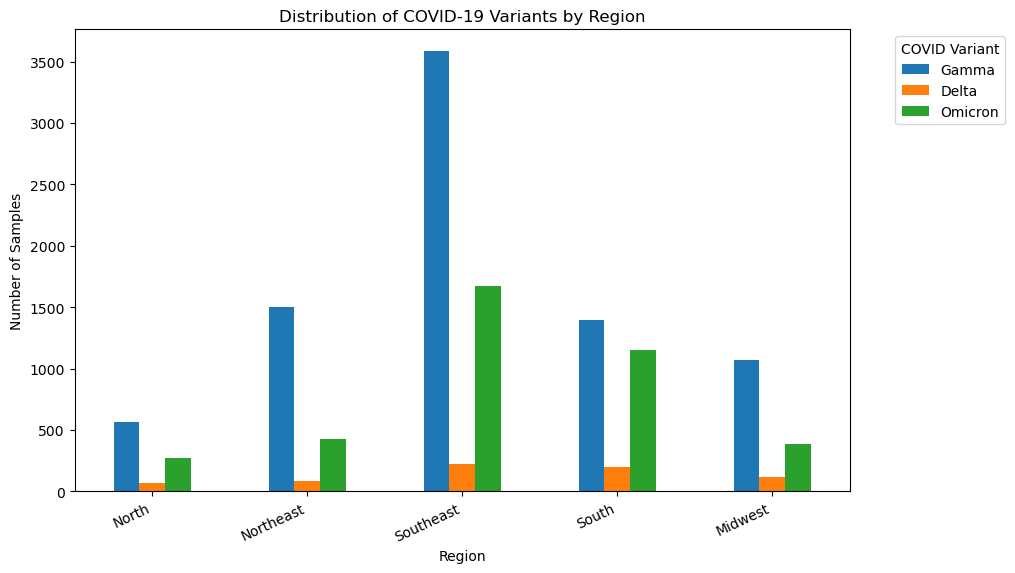

,Gamma,Gamma_Percentage,Delta,Delta_Percentage,Omicron,Omicron_Percentage,Total
North,568,7.0%,69,9.93%,269,6.88%,906
Northeast,1500,18.48%,88,12.66%,426,10.9%,2014
Southeast,3582,44.13%,221,31.8%,1675,42.85%,5478
South,1394,17.17%,197,28.35%,1154,29.52%,2745
Midwest,1073,13.22%,120,17.27%,385,9.85%,1578
Total,8117,100.0%,695,100.0%,3909,100.0%,12721


H₀: The two categorical variables have no relationship
p-value : 0.0

Null Hypothesis is rejected.


In [52]:
labels = FAIXA_REGIAO

# Create a DataFrame for plotting
plot_df = pd.DataFrame(index=labels)

# Count the number of people for each variant by region
for variant in df['VARIANTE_COVID'].unique():
    variant_counts = df[df['VARIANTE_COVID'] == variant].groupby('Regiao_nome').size()
    plot_df[variant] = variant_counts

plot_df.rename(columns={1: 'Gamma', 2: 'Delta', 3: 'Omicron'}, inplace=True)

# Plot the grouped bar chart
ax = plot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Distribution of COVID-19 Variants by Region')
plt.xlabel('Region')
plt.ylabel('Number of Samples')
plt.legend(title='COVID Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha="right")
plt.show()

# Add 'Total' column
plot_df['Total'] = plot_df.sum(axis=1)

# Add 'Total' row
plot_df.loc['Total'] = plot_df.sum()

percentage_df = plot_df.copy()
# Add percentage columns
for variant in ['Gamma', 'Delta', 'Omicron']:
    percentage_df[variant + '_Percentage'] = (percentage_df[variant] / percentage_df.loc['Total'][variant] * 100).round(2).astype(str) + '%'

column_order = ['Gamma', 'Gamma_Percentage', 'Delta', 'Delta_Percentage', 'Omicron', 'Omicron_Percentage', 'Total']
percentage_df = percentage_df[column_order]
display(percentage_df)

#calculation of p-value : What is the evidence of a correlation between age (in general) and the type of covid variant?

alpha = 0.05
chi_square = 0
columns = plot_df.iloc[:,0:3].columns
rows = plot_df.iloc[0:3].index
for i in columns:
  for j in rows:
    O = plot_df[i][j] #observed value
    E = plot_df[i]['Total'] *plot_df['Total'][j] / plot_df['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E


p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

relationship between chronic cardiovascular disease and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.9389870557489737

Failed to reject the null hypothesis.



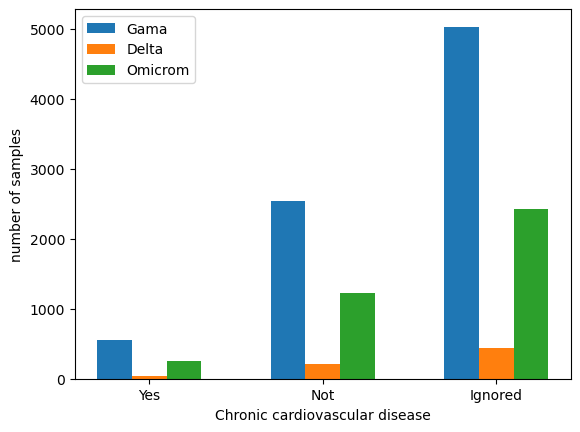


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,556 (6.85),42 (6.04),259 (6.63)
Not,2534 (31.22),217 (31.22),1223 (31.29)
Ignored,5027 (61.93),436 (62.73),2427 (62.09)


In [145]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_cardio_vascular = df['CARDIOPATI'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_cardio_vascular[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_cardio_vascular[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_cardio_vascular[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Chronic cardiovascular disease")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Cardiovascular = df_table_int.iloc[0:3 :,0:3]
df_Cardiovascular = df_Cardiovascular.astype(int)
df_Cardiovascular['Gama N (%)'] = df_table['Gama N (%) ']
df_Cardiovascular['Delta N (%)'] = df_table['Delta N (%) ']
df_Cardiovascular['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Cardiovascular = df_Cardiovascular.astype(str)

df_Cardiovascular['Gama N'] = df_Cardiovascular.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Cardiovascular['Delta N'] = df_Cardiovascular.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Cardiovascular['Omicrom N'] = df_Cardiovascular.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Cardiovascular.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Cardiovascular)

Relationship between kidney disease and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8476796876269977

Failed to reject the null hypothesis.



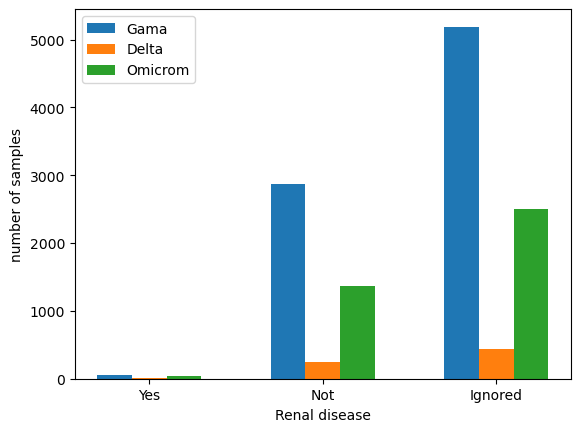


-------------  Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,57 (0.7),7 (1.01),33 (0.84)
Not,2870 (35.36),244 (35.11),1369 (35.02)
Ignored,5190 (63.94),444 (63.88),2507 (64.13)


In [146]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_renal = df['RENAL'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_renal[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_renal[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_renal[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Renal disease")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('-------------  Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Renal = df_table_int.iloc[0:3 :,0:3]
df_Renal = df_Renal.astype(int)
df_Renal['Gama N (%)'] = df_table['Gama N (%) ']
df_Renal['Delta N (%)'] = df_table['Delta N (%) ']
df_Renal['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Renal = df_Renal.astype(str)

df_Renal['Gama N'] = df_Renal.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Renal['Delta N'] = df_Renal.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Renal['Omicrom N'] = df_Renal.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Renal.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Renal)

relationship between asthma and covid variants


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.8734932457705911

Failed to reject the null hypothesis.



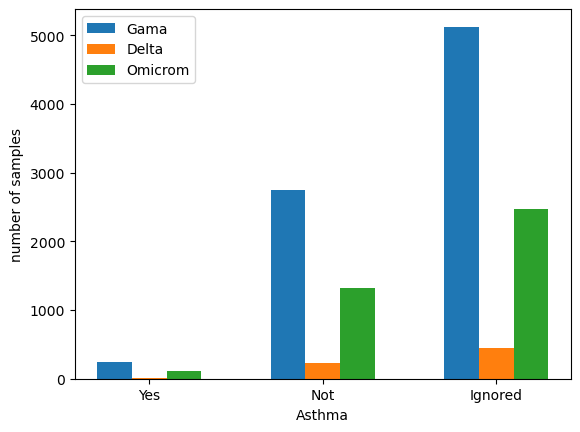


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,246 (3.03),16 (2.3),117 (2.99)
Not,2744 (33.81),235 (33.81),1315 (33.64)
Ignored,5127 (63.16),444 (63.88),2477 (63.37)


In [147]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_asma = df['ASMA'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_asma[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_asma[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_asma[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Asthma")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Asma = df_table_int.iloc[0:3 :,0:3]
df_Asma = df_Asma.astype(int)
df_Asma['Gama N (%)'] = df_table['Gama N (%) ']
df_Asma['Delta N (%)'] = df_table['Delta N (%) ']
df_Asma['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Asma = df_Asma.astype(str)

df_Asma['Gama N'] = df_Asma.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Asma['Delta N'] = df_Asma.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Asma['Omicrom N'] = df_Asma.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Asma.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Asma)

relationship between diabetes mellitus and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.40653323299817423

Failed to reject the null hypothesis.



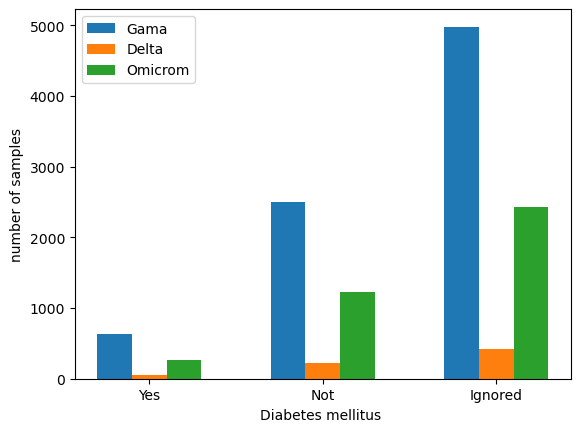


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,629 (7.75),49 (7.05),264 (6.75)
Not,2507 (30.89),219 (31.51),1221 (31.24)
Ignored,4981 (61.37),427 (61.44),2424 (62.01)


In [148]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_diabetes= df['DIABETES'].tolist()
lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

for i in range(len(df[selecao_gama])):
   concat1=[lista_diabetes[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_diabetes[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_diabetes[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1 = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2 =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3 = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

matrix_table_int = np.array([y1,y2,y3]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1, width, label = 'Gama')
plt.bar(x, y2, width, label = 'Delta')
plt.bar(x+0.2, y3, width, label = 'Omicrom')
plt.xlabel("Diabetes mellitus ")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1[:] = [float(i) / sum(y1) for i in y1]
y2[:] = [float(i) / sum(y2) for i in y2]
y3[:] = [float(i) / sum(y3) for i in y3]


y1 = [x*100 for x in y1]
y2 = [x*100 for x in y2]
y3 = [x*100 for x in y3]

y1 = [round(x,2) for x in y1]
y2 = [round(x,2) for x in y2]
y3 = [round(x,2) for x in y3]

matrix_table = np.array([y1,y2,y3])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_Diabetes_mellitus = df_table_int.iloc[0:3 :,0:3]
df_Diabetes_mellitus = df_Diabetes_mellitus.astype(int)
df_Diabetes_mellitus['Gama N (%)'] = df_table['Gama N (%) ']
df_Diabetes_mellitus['Delta N (%)'] = df_table['Delta N (%) ']
df_Diabetes_mellitus['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_Diabetes_mellitus = df_Diabetes_mellitus.astype(str)

df_Diabetes_mellitus['Gama N'] = df_Diabetes_mellitus.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_Diabetes_mellitus['Delta N'] = df_Diabetes_mellitus.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_Diabetes_mellitus['Omicrom N'] = df_Diabetes_mellitus.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_Diabetes_mellitus.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_Diabetes_mellitus)

relationship between other medical conditions and covid variant


------------- Valor p  : ----------------

H₀: The two categorical variables have no relationship
p-value : 0.718364085129457

Failed to reject the null hypothesis.



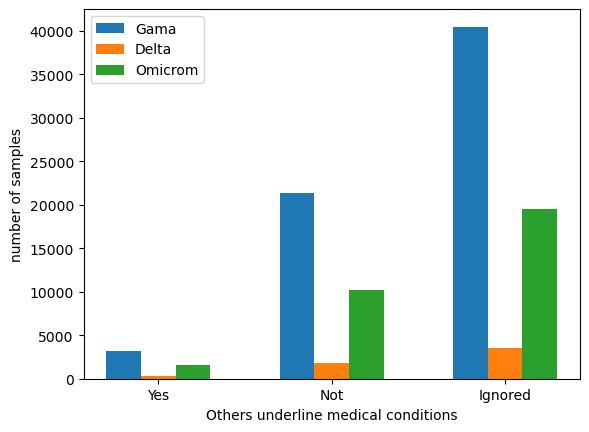


------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------



,Gama N,Delta N,Omicrom N
Yes,3142 (4.84),288 (5.18),1551 (4.96)
Not,21321 (32.83),1797 (32.32),10229 (32.71)
Ignored,40473 (62.33),3475 (62.5),19492 (62.33)


In [149]:
# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_outros= df['OUT_MORBI'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_outros[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_outros[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_outros[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_outros = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_outros =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_outros = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_hematológica = df['HEMATOLOGI'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_hematológica[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_hematológica[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_hematológica[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_hematológica = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_hematológica =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_hematológica = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_sind_down = df['SIND_DOWN'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_sind_down[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_sind_down[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_sind_down[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_sind_down = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_sind_down =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_sind_down = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_hepatica = df['HEPATICA'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_hepatica[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_hepatica[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_hepatica[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_hepatica = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_hepatica =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_hepatica = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_neurologica = df['NEUROLOGIC'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_neurologica[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_neurologica[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_neurologica[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_neurologica = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_neurologica =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_neurologica = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_pneumopatia = df['PNEUMOPATI'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_pneumopatia[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_pneumopatia[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_pneumopatia[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_pneumopatia = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_pneumopatia =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_pneumopatia = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_imuno_depre = df['IMUNODEPRE'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_imuno_depre[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_imuno_depre[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_imuno_depre[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_imuno_depre = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_imuno_depre =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_imuno_depre = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#------------------------------------------------------------------------------

# criando datasets que separam as variantes
selecao_gama = (df['DT_COLETA'] >= '2021-03-01') & (df['DT_COLETA'] <= '2021-07-30')
selecao_delta = (df['DT_COLETA'] >= '2021-09-01') & (df['DT_COLETA'] <= '2021-11-30')
selecao_omicrom = (df['DT_COLETA'] >= '2022-01-01') & (df['DT_COLETA'] <= '2022-08-30')

df_selecao_gama = df[selecao_gama]
df_selecao_delta = df[selecao_delta]
df_selecao_omicrom = df[selecao_omicrom]

lista_gama = df[selecao_gama]['DT_COLETA'].tolist()
lista_delta = df[selecao_delta]['DT_COLETA'].tolist()
lista_omicrom = df[selecao_omicrom]['DT_COLETA'].tolist()
resultados_gama=[]
resultados_delta=[]
resultados_omicrom=[]

for i in range(len(lista_gama)):
  lista_gama[i] = 1 # definindo variante gama como 1

for i in range(len(lista_delta)):
  lista_delta[i] = 2 # definindo variante delta como 2

for i in range(len(lista_omicrom)):
  lista_omicrom[i] = 3 # definindo variante omicrom como 3

lista_obesidade = df['OBESIDADE'].tolist()

for i in range(len(df[selecao_gama])):
   concat1=[lista_obesidade[i],lista_gama[i]]
   resultados_gama.append(concat1)
for i in range(len(df[selecao_delta])):
   concat2=[lista_obesidade[i],lista_delta[i]]
   resultados_delta.append(concat2)
for i in range(len(df[selecao_omicrom])):
   concat3=[lista_obesidade[i],lista_omicrom[i]]
   resultados_omicrom.append(concat3)

resultados = resultados_gama + resultados_delta + resultados_omicrom

Faixa = ['Yes','Not','Ignored']

lista_1 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 1:
    lista_1.append(resultados[i][1])

lista_2 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 2:
    lista_2.append(resultados[i][1])

lista_3 = []
for i in range(len(resultados)) :
  if resultados[i][0] == 9:
    lista_3.append(resultados[i][1])

y1_obesidade = [lista_1.count(1),lista_2.count(1), lista_3.count(1)]
y2_obesidade =[lista_1.count(2),lista_2.count(2), lista_3.count(2)]
y3_obesidade = [lista_1.count(3),lista_2.count(3), lista_3.count(3)]

#-------------------------------------------------------------------------

y1_total_outros = [A + B + C + D + E + F + G + H for A , B , C , D , E , F , G , H in zip(y1_outros,y1_hematológica, y1_sind_down,y1_hepatica,y1_neurologica,y1_pneumopatia, y1_imuno_depre,y1_obesidade)]
y2_total_outros = [A + B + C + D + E + F + G + H for A , B , C , D , E , F , G , H in zip(y2_outros,y2_hematológica,y2_sind_down,y2_hepatica,y2_neurologica,y2_pneumopatia, y2_imuno_depre,y2_obesidade)]
y3_total_outros = [A + B + C + D + E + F + G + H for A , B , C , D , E , F , G , H in zip(y3_outros,y3_hematológica,y3_sind_down,y3_hepatica,y3_neurologica,y3_pneumopatia, y3_imuno_depre,y3_obesidade)]

matrix_table_int = np.array([y1_total_outros,y2_total_outros,y3_total_outros]).transpose()
df_table_int = pd.DataFrame(matrix_table_int, columns=['Gama N', 'Delta N', 'Omicrom N'], index = Faixa)
df_table_int.loc['Total',:]= df_table_int.sum(axis=0)
df_table_int.loc[:,'Total'] = df_table_int.sum(axis=1)

#calculo do p-value : Qual a evidência de uma correlação entre a idade (no geral) e o tipo de variante do covid?
alpha = 0.05
chi_square = 0
columns = df_table_int.iloc[:,0:3].columns
rows = df_table_int.iloc[0:3].index
for i in columns:
  for j in rows:
    O = df_table_int[i][j] #observed value
    E = df_table_int[i]['Total'] *df_table_int['Total'][j] / df_table_int['Total']['Total'] # expected frequency
    chi_square += (O-E)**2/E

print()
print('------------- Valor p  : ----------------')
print()

p_value = 1 - stats.chi2.cdf(chi_square, (len(rows)-1)*(len(columns)-1)) #The number of degrees of freedom of the χ2 independence test statistics: d.f. = (# rows -1) *(#columns-1)
print('H₀: The two categorical variables have no relationship')
print('p-value :',p_value)
print()
conclusion = "Failed to reject the null hypothesis."
if p_value <= alpha:
    conclusion = "Null Hypothesis is rejected."
print(conclusion)

print()

width = 0.2

x = np.arange(len(Faixa))

plt.bar(x-0.2, y1_total_outros, width, label = 'Gama')
plt.bar(x, y2_total_outros, width, label = 'Delta')
plt.bar(x+0.2, y3_total_outros, width, label = 'Omicrom')
plt.xlabel("Others underline medical conditions")
plt.ylabel("number of samples")
plt.xticks(x, Faixa)
plt.legend()
plt.show()

print()
print('------------- Total value and Percentage for the Gamma, Delta and Omicrom variants, respectively : ----------------')
print()

y1_total_outros[:] = [float(i) / sum(y1_total_outros) for i in y1_total_outros]
y2_total_outros[:] = [float(i) / sum(y2_total_outros) for i in y2_total_outros]
y3_total_outros[:] = [float(i) / sum(y3_total_outros) for i in y3_total_outros]

y1_total_outros = [x*100 for x in y1_total_outros]
y2_total_outros = [x*100 for x in y2_total_outros]
y3_total_outros = [x*100 for x in y3_total_outros]

y1_total_outros = [round(x,2) for x in y1_total_outros]
y2_total_outros = [round(x,2) for x in y2_total_outros]
y3_total_outros = [round(x,2) for x in y3_total_outros]

matrix_table = np.array([y1_total_outros,y2_total_outros,y3_total_outros])
matrix_table = matrix_table.transpose()
df_table = pd.DataFrame(matrix_table, columns=['Gama N (%) ', 'Delta N (%) ', 'Omicrom N (%)'], index = Faixa)

df_outras_condicoes_medicas = df_table_int.iloc[0:3 :,0:3]
df_outras_condicoes_medicas = df_outras_condicoes_medicas.astype(int)
df_outras_condicoes_medicas['Gama N (%)'] = df_table['Gama N (%) ']
df_outras_condicoes_medicas['Delta N (%)'] = df_table['Delta N (%) ']
df_outras_condicoes_medicas['Omicrom N (%)'] = df_table['Omicrom N (%)']
df_outras_condicoes_medicas = df_outras_condicoes_medicas.astype(str)

df_outras_condicoes_medicas['Gama N'] = df_outras_condicoes_medicas.apply(lambda x: x['Gama N'] + ' (' + x['Gama N (%)'] + ')', axis=1)
df_outras_condicoes_medicas['Delta N'] = df_outras_condicoes_medicas.apply(lambda x: x['Delta N'] + ' (' + x['Delta N (%)'] + ')', axis=1)
df_outras_condicoes_medicas['Omicrom N'] = df_outras_condicoes_medicas.apply(lambda x: x['Omicrom N'] + ' (' + x['Omicrom N (%)'] + ')', axis=1)
df_outras_condicoes_medicas.drop(columns = ['Gama N (%)','Delta N (%)','Omicrom N (%)'], inplace = True)
display(df_outras_condicoes_medicas)

Tabela 1: Características sociodemográficas e obstétricas de mulheres com infecção por SARS-CoV-2 confirmada laboratorialmente.

In [150]:
df_Asma['Classe'] = 'Asma'
df_Cardiovascular['Classe'] ='Cardiovascular'
df_Diabetes_mellitus['Classe']='Diabetes_mellitus'
df_Renal['Classe']='Renal'
df_escolaridade['Classe']='escolaridade'
df_gestante['Classe']='gestante'
df_regiao['Classe']='regiao'
df_outras_condicoes_medicas['Classe']='outras_condicoes_medicas'
df_vacina['Classe']='vacina'
df_idade['Classe'] = 'Idade'
df_raca['Classe'] = 'Raça'

df_concatenado_tabela1 = pd.concat([df_idade,df_raca,df_regiao,df_escolaridade,df_vacina,df_gestante,df_Cardiovascular,df_Renal,df_Asma,df_Diabetes_mellitus,df_outras_condicoes_medicas])
colunas_concat = df_concatenado_tabela1.columns.tolist()
colunas_concat.remove("Classe")
grupos = df_concatenado_tabela1[colunas_concat].groupby(df_concatenado_tabela1["Classe"])
for nome_grupo, grupo_df in grupos:
    print("Classe: ", nome_grupo)
    print(grupo_df)
    print("\n")

Classe:  Asma
               Gama N      Delta N     Omicrom N Total
Yes        246 (3.03)     16 (2.3)    117 (2.99)   NaN
Not      2744 (33.81)  235 (33.81)  1315 (33.64)   NaN
Ignored  5127 (63.16)  444 (63.88)  2477 (63.37)   NaN


Classe:  Cardiovascular
               Gama N      Delta N     Omicrom N Total
Yes        556 (6.85)    42 (6.04)    259 (6.63)   NaN
Not      2534 (31.22)  217 (31.22)  1223 (31.29)   NaN
Ignored  5027 (61.93)  436 (62.73)  2427 (62.09)   NaN


Classe:  Diabetes_mellitus
               Gama N      Delta N     Omicrom N Total
Yes        629 (7.75)    49 (7.05)    264 (6.75)   NaN
Not      2507 (30.89)  219 (31.51)  1221 (31.24)   NaN
Ignored  4981 (61.37)  427 (61.44)  2424 (62.01)   NaN


Classe:  Idade
             Gama N      Delta N    Omicrom N Total
0-19     534 (6.58)    45 (6.47)   129 (7.22)   708
20-24  1279 (15.76)    98 (14.1)  258 (14.45)  1635
25-29  1805 (22.24)   155 (22.3)  399 (22.34)  2359
30-34  1967 (24.23)  158 (22.73)  436 (24.41) 

**Notes


* The dataset does not contain information on parity
* The dataset does not contain information on marital status
* The df['VACINA_COV'] column does not contain the relation: complete vaccination : 1, and incomplete vaccination : 2 , but rather the relation: at least 1 dose : 1 , and no dose :2 . Thus, to determine whether the vaccination was complete (2 doses or more), we need to look at the dates of the doses, but these variables have many NaNs

